Most common NP-sequences:

[('(-NONE-,)', 171), ('(DT, NN)', 134), ('(PRP,)', 68), ('(NNP, NNP)', 61), ('(NNS,)', 57), ('(NNP, NNP, NNP)', 55), ('(NNP,)', 50), ('(NN,)', 45), ('(QP, -NONE-)', 44), ('(DT, JJ, NN)', 40)]



Histogram of NP-sequence lengths


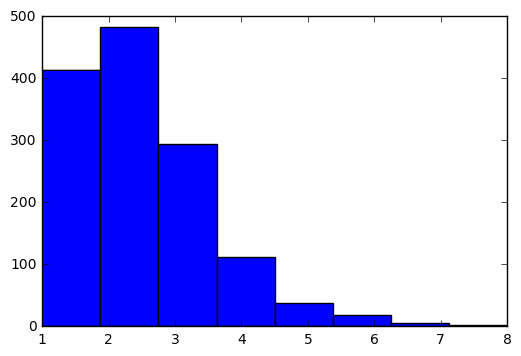

In [1]:
from nltk.corpus import treebank
from nltk.tree import Tree
from nltk.tree import ParentedTree
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np




# open questions:
# > should we only look for 'NP' or also for 'NP-SBJ' and so on?


# file ids of the treebank:
fileIds = treebank.fileids()

cutPointTestData = int(len(fileIds) * 0.9)

# list of all non-recursive sequences for NP:
nprhss = []
allrhss = []
lengths = []  
for fileId in fileIds[0:cutPointTestData]:
    
    tree = treebank.parsed_sents(fileId)[0]
    productions = tree.productions()
    
    for production in productions:
        
        lhs = production.lhs()
        rhs = production.rhs()

        if str(lhs).startswith('NP'):
        # if str(lhs).strip() == 'NP':
            # check if rhs is recursive (contains another NP):
            isRecursive = False
            for el in rhs:
                if str(el).startswith('NP'):
                # if str(el).strip() == 'NP':
                    isRecursive = True
            if  not isRecursive: 
                # only add non-recursive rhs:
                nprhss.append(str(rhs))
                # save rhs lengths for histogram:
                lengths.append(len(rhs))
        
        # add all rhs found to allrhss
        allrhss.append(str(rhs))

npGrammar = Counter(nprhss)
allGrammar = Counter(allrhss)

# create a probabilistic grammar (PCFG) based on relative frequency:
probNpGrammar = Counter()
for rule in npGrammar:
    probNpGrammar[rule] = npGrammar[rule]/len(nprhss)
    
# calculate conditional probabilities P(NP|sequence):
# for any sequence that is a NP at least one:
# (number of times this sequence was a NP) / (number of times this sequence occurred)
probNpGivenSequence = Counter()
for rule in npGrammar:
    # also count the length of the NP-sequences
    probNpGivenSequence[rule] = npGrammar[rule] / allGrammar[rule]

print('Most common NP-sequences:\n')
print(npGrammar.most_common(10))

shortestNpSeq = np.min(lengths)
longestNpSeq = np.max(lengths)
print('\n\n\nHistogram of NP-sequence lengths')
plt.hist(lengths, (longestNpSeq - shortestNpSeq + 1))
plt.show()


In [2]:
npProbThreshold = 0.5

TP = 0
FP = 0
TN = 0
FN = 0

for fileId in fileIds[cutPointTestData:-1]:
    
    thisFileLabels = []
    thisFileActualClass = []
    
    tree = treebank.parsed_sents(fileId)[0]
    ptree = ParentedTree.fromstring(str(tree))
    leaves = ptree.leaves()
    
    poss = []
    for leaf in leaves:
        leafIndex = leaves.index(leaf)
        treeLocation = ptree.leaf_treeposition(leafIndex)
        leaveParent = str(ptree[treeLocation[:-1]]).split(" ")
        pos = leaveParent[0][1:]
        poss.append(pos)

    startPos = 0  
    while startPos < len(poss):
        longestNpLength = 0
        longestNp = None
        for endPos in range(startPos, len(poss)):
            if (endPos - startPos + 1) > longestNpSeq:
                break
            sequence = '(' + poss[startPos]
            if startPos == endPos:
                sequence = sequence + ','
            else:
                for seqPos in range(startPos+1, endPos +1):
                    sequence = sequence + ', ' + poss[seqPos]
            sequence = sequence + ')'
            probIsNp = probNpGivenSequence[sequence]
            if probIsNp >= npProbThreshold:
                longestNpLength = endPos - startPos
                longestNp = sequence
                longestNpLeaves = leaves[startPos:endPos+1]
                longesNpProb = probNpGivenSequence[sequence]
      
        for i in range(0, longestNpLength + 1):
            
            # get the actual class of each word (NP or non-NP):
            leaf = leaves[startPos+i]
            leafIndex = leaves.index(leaf)
            treeLocation = ptree.leaf_treeposition(leafIndex)
            leaveParent = str(ptree[treeLocation[:-2]]).split(" ")
            pos = str(leaveParent[0][1:]).strip()
            if str(pos).startswith('NP'):
                thisFileActualClass.append(1)
            else:
                thisFileActualClass.append(0)
            
            # save the classified labels for evaluation
            if longestNp == None:
                thisFileLabels.append(0)
            else:
                thisFileLabels.append(1)
        
        startPos = startPos + longestNpLength
        startPos = startPos + 1
                
    for i in range(0, len(thisFileLabels)) :
        if thisFileLabels[i] == 1:
            if thisFileActualClass[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if thisFileActualClass[i] == 0:
                TN += 1
            else:
                FN += 1

            
print('TP: ' + str(TP))
print('FP: ' + str(FP))
print('TN: ' + str(TN))
print('FN: ' + str(FN))

acc = (TP + TN) / (TP + FP + TN + FN)
TPR = (TP) / (TP + FN)

print()
print('TPR: ' + str(TPR))
print('Accuracy: ' + str(acc))

TP: 328
FP: 36
TN: 159
FN: 49

TPR: 0.870026525198939
Accuracy: 0.8513986013986014


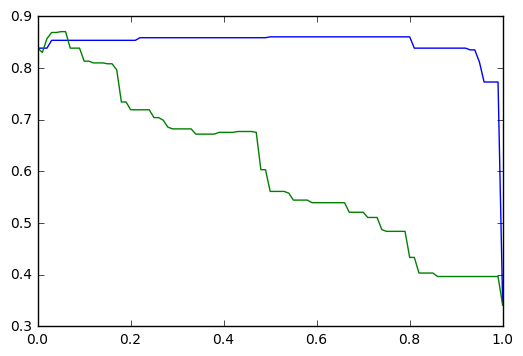

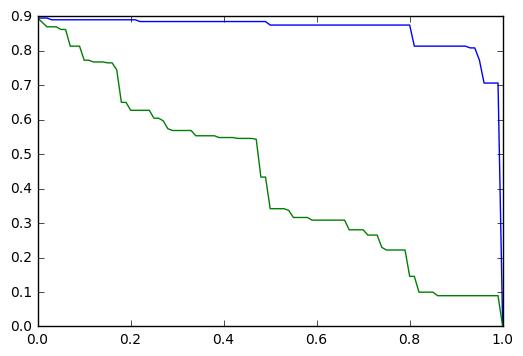

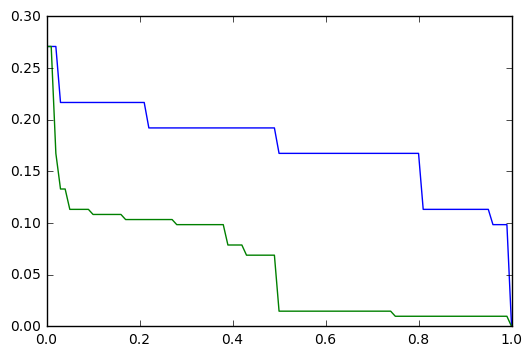

0.860504201681
0.870588235294
0.895408163265
0.895408163265


In [25]:
accs1 = [0.838655462184874, 0.838655462184874, 0.838655462184874, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.853781512605042, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8588235294117647, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.8605042016806723, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.8352941176470589, 0.8352941176470589, 0.8117647058823529, 0.773109243697479, 0.773109243697479, 0.773109243697479, 0.773109243697479, 0.3411764705882353]
accs2 = [0.838655462184874, 0.8302521008403362, 0.8571428571428571, 0.8689075630252101, 0.8689075630252101, 0.8705882352941177, 0.8705882352941177, 0.838655462184874, 0.838655462184874, 0.838655462184874, 0.8134453781512605, 0.8134453781512605, 0.8100840336134454, 0.8100840336134454, 0.8100840336134454, 0.8084033613445378, 0.8084033613445378, 0.7966386554621848, 0.7344537815126051, 0.7344537815126051, 0.719327731092437, 0.719327731092437, 0.719327731092437, 0.719327731092437, 0.719327731092437, 0.704201680672269, 0.704201680672269, 0.6991596638655462, 0.6857142857142857, 0.6823529411764706, 0.6823529411764706, 0.6823529411764706, 0.6823529411764706, 0.6823529411764706, 0.6722689075630253, 0.6722689075630253, 0.6722689075630253, 0.6722689075630253, 0.6722689075630253, 0.6756302521008404, 0.6756302521008404, 0.6756302521008404, 0.6756302521008404, 0.6773109243697479, 0.6773109243697479, 0.6773109243697479, 0.6773109243697479, 0.6756302521008404, 0.6033613445378151, 0.6033613445378151, 0.561344537815126, 0.561344537815126, 0.561344537815126, 0.561344537815126, 0.5579831932773109, 0.5445378151260504, 0.5445378151260504, 0.5445378151260504, 0.5445378151260504, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5394957983193277, 0.5210084033613446, 0.5210084033613446, 0.5210084033613446, 0.5210084033613446, 0.5109243697478991, 0.5109243697478991, 0.5109243697478991, 0.48739495798319327, 0.48403361344537815, 0.48403361344537815, 0.48403361344537815, 0.48403361344537815, 0.48403361344537815, 0.4336134453781513, 0.4336134453781513, 0.40336134453781514, 0.40336134453781514, 0.40336134453781514, 0.40336134453781514, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.39663865546218485, 0.3411764705882353]

tprs1 = [0.8954081632653061, 0.8954081632653061, 0.8954081632653061, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8903061224489796, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.8852040816326531, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.8086734693877551, 0.8086734693877551, 0.7729591836734694, 0.7066326530612245, 0.7066326530612245, 0.7066326530612245, 0.7066326530612245, 0.0]
tprs2 = [0.8954081632653061, 0.8826530612244898, 0.8698979591836735, 0.8698979591836735, 0.8698979591836735, 0.8622448979591837, 0.8622448979591837, 0.8137755102040817, 0.8137755102040817, 0.8137755102040817, 0.7729591836734694, 0.7729591836734694, 0.7678571428571429, 0.7678571428571429, 0.7678571428571429, 0.7653061224489796, 0.7653061224489796, 0.7448979591836735, 0.6505102040816326, 0.6505102040816326, 0.6275510204081632, 0.6275510204081632, 0.6275510204081632, 0.6275510204081632, 0.6275510204081632, 0.6045918367346939, 0.6045918367346939, 0.5969387755102041, 0.5739795918367347, 0.5688775510204082, 0.5688775510204082, 0.5688775510204082, 0.5688775510204082, 0.5688775510204082, 0.5535714285714286, 0.5535714285714286, 0.5535714285714286, 0.5535714285714286, 0.5535714285714286, 0.548469387755102, 0.548469387755102, 0.548469387755102, 0.548469387755102, 0.5459183673469388, 0.5459183673469388, 0.5459183673469388, 0.5459183673469388, 0.5433673469387755, 0.4336734693877551, 0.4336734693877551, 0.34183673469387754, 0.34183673469387754, 0.34183673469387754, 0.34183673469387754, 0.336734693877551, 0.3163265306122449, 0.3163265306122449, 0.3163265306122449, 0.3163265306122449, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.3086734693877551, 0.28061224489795916, 0.28061224489795916, 0.28061224489795916, 0.28061224489795916, 0.2653061224489796, 0.2653061224489796, 0.2653061224489796, 0.22959183673469388, 0.22193877551020408, 0.22193877551020408, 0.22193877551020408, 0.22193877551020408, 0.22193877551020408, 0.14540816326530612, 0.14540816326530612, 0.09948979591836735, 0.09948979591836735, 0.09948979591836735, 0.09948979591836735, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.08928571428571429, 0.0]

fprs1 = [0.270935960591133, 0.270935960591133, 0.270935960591133, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.21674876847290642, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.1921182266009852, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.16748768472906403, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.0]
fprs2 = [0.270935960591133, 0.270935960591133, 0.16748768472906403, 0.1330049261083744, 0.1330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.11330049261083744, 0.10837438423645321, 0.10837438423645321, 0.10837438423645321, 0.10837438423645321, 0.10837438423645321, 0.10837438423645321, 0.10837438423645321, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.10344827586206896, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.09852216748768473, 0.07881773399014778, 0.07881773399014778, 0.07881773399014778, 0.07881773399014778, 0.06896551724137931, 0.06896551724137931, 0.06896551724137931, 0.06896551724137931, 0.06896551724137931, 0.06896551724137931, 0.06896551724137931, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.014778325123152709, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.009852216748768473, 0.0]

ns = []
for i in range(0,101):
    ns.append(float(i)/100)

    
plt.plot(ns, accs1)
plt.plot(ns, accs2)
plt.show()

plt.plot(ns, tprs1)
plt.plot(ns, tprs2)
plt.show()

plt.plot(ns, fprs1)
plt.plot(ns, fprs2)
plt.show()

print(np.max(accs1))
print(np.max(accs2))

print(np.max(tprs1))
print(np.max(tprs2))

[S -> NP-SBJ VP ., NP-SBJ -> NP , ADJP ,, NP -> NNP NNP, NNP -> 'Pierre', NNP -> 'Vinken', , -> ',', ADJP -> NP JJ, NP -> CD NNS, CD -> '61', NNS -> 'years', JJ -> 'old', , -> ',', VP -> MD VP, MD -> 'will', VP -> VB NP PP-CLR NP-TMP, VB -> 'join', NP -> DT NN, DT -> 'the', NN -> 'board', PP-CLR -> IN NP, IN -> 'as', NP -> DT JJ NN, DT -> 'a', JJ -> 'nonexecutive', NN -> 'director', NP-TMP -> NNP CD, NNP -> 'Nov.', CD -> '29', . -> '.']


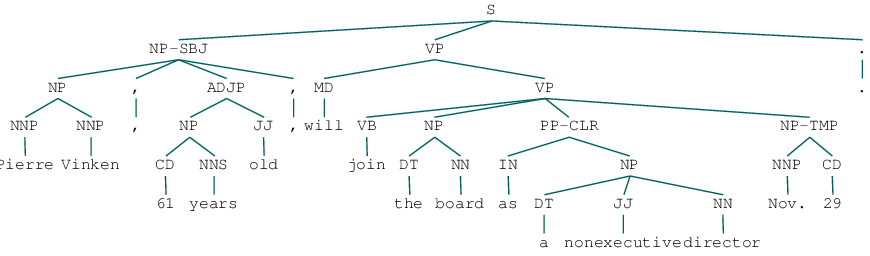

In [27]:
fileIds = treebank.fileids()

cutPointTestData = int(len(fileIds) * 0.9)

nprhss = []
allrhss = []
lengths = []  
for fileId in fileIds[0:1]:
    
    tree = treebank.parsed_sents(fileId)[0]
    productions = tree.productions()
    print(productions)
    
tree